## Second Order vs First Order Optimization

This notebook discusses the optimization techniques to understand the role of first and second order derivatives for improving weights of the model

In [1]:
# Dependencies

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


### Toy Data

Getting some data to test both the optimizations implemented here.
Source: http://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/mlr/frames/mlr02.html

X1: Systolic Blood Pressure
X2: Age in years
X2: Weight in pounds

The linear model will try to predict *Systolic Blood Pressure* based on *Age in years* and *Weight in pounds*

In [2]:
def plot_figure(x, y, z, weights=None, X=None, mu=0, std=1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(240, 60)
    ax.scatter(x,y,z)
    ax.set_xlabel('Age in years')
    ax.set_ylabel('Weight in pounds')
    ax.set_zlabel('Systolic Blood Pressure')
    if weights is not None and X is not None:
        xmin, xmax = np.min(X[:,1]) - 0.5, np.max(X[:,1]) + 0.5
        ymin, ymax = np.min(X[:,2]) - 0.5, np.max(X[:,2]) + 0.5
        xdata = np.linspace(xmin, xmax, 10)
        ydata = np.linspace(ymin, ymax, 10)
        pred = weights[0] + weights[1]*xdata + weights[2]*ydata
        x_plot_data = xdata*std[0] + mu[0]
        y_plot_data = ydata*std[1] + mu[1]
        ax.plot(x_plot_data, y_plot_data, pred, color='r')
    plt.show()
    return


In [3]:
df = pd.read_csv("/Users/neha.arora/Documents/github/The_Math_Of_Intelligence/week2/data_1.csv", header=None)
df = df.loc[1:].dropna()
df = df.values.astype(float)
X = df[:, 1:]

# Normalize features
mu = np.mean(X, axis=0)
sd = np.std(X, axis=0)
Xnorm = (X-mu)/sd

XTemp = np.ones((Xnorm.shape[0], Xnorm.shape[1]+1))
XTemp[:,1:] = Xnorm
Xnorm = XTemp

print ("Normalized features:\n", Xnorm)

y = df[:, 0]
weights = np.zeros(Xnorm.shape[1])

print ("Predictions: ", y)


Normalized features:
 [[ 1.         -1.20301838 -1.33261043]
 [ 1.         -0.39751912 -0.66630522]
 [ 1.          0.52305147 -0.0605732 ]
 [ 1.          1.21347941  0.96917122]
 [ 1.          0.1778375   0.0605732 ]
 [ 1.          1.32855074  1.51433004]
 [ 1.         -0.97287574 -0.42401241]
 [ 1.         -0.16737647 -0.42401241]
 [ 1.          0.29290882  0.72687842]
 [ 1.         -1.89344632 -1.69604964]
 [ 1.          1.09840809  1.33261043]]
Predictions:  [ 132.  143.  153.  162.  154.  168.  137.  149.  159.  128.  166.]


Initial Weights:  [-0.00637903 -0.01753382  0.00844433]
Prediction with initial guess of weights


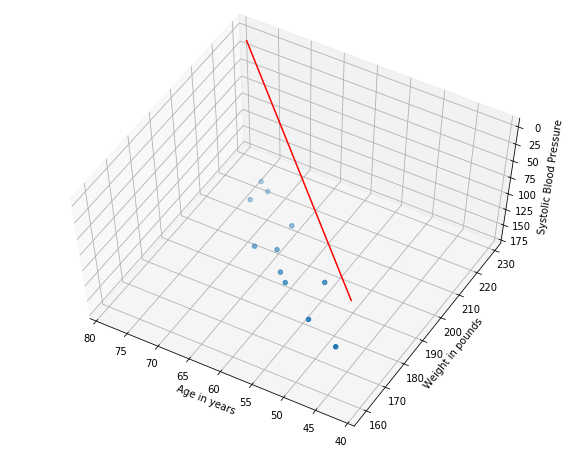

In [4]:
# Initialize weights
std = 1e-2
for i in range(len(weights)):
    weights[i] = np.random.randn() * std
    
print ("Initial Weights: ", weights)

print("Prediction with initial guess of weights")
plot_figure(X[:,0], X[:,1], y, weights, Xnorm, mu, sd)

In [5]:
'''
Get the intercept term added in features
'''
def X_with_bias(X):
    Xtemp = np.ones((X.shape[0], X.shape[1]+1))
    XTemp[:,1:] = X
    return Xtemp

'''
Returns the sum of squared errors
'''
def compute_total_error(f, X, y, W):
    pred = f(X, W)
    diff = pred - y
    sse = diff.dot(diff.T)/len(X)
    return sse


'''
Linear function: f(X, W) = X1W1 + X2W2 + ... + XnWn
'''
def f(X, W):
    return X.dot(W)

# Computing the initial error
initial_error = compute_total_error(f, Xnorm, y, weights)
print ("Initial Error: ", initial_error)

Initial Error:  22698.238863


In [6]:
'''
For unknown function, compute derivative of f using first principle
'''
def Jacobian(X, W, y, f, h=1e-5): 
    N = len(W)
    jacobian = np.zeros(N)
    for i in range(N):
        wts = np.zeros(N)
        wts[i] = W[i]+h
        Eplus = compute_total_error(f, X, y, wts)
        wts[i] = W[i]-h
        Eminus = compute_total_error(f, X, y, wts)
        jacobian[i] = (Eplus - Eminus)/(2*h)
    return jacobian

# Compute the first set of derivatives
j0 = Jacobian(Xnorm, weights, y, f)
print ("Initially computed Jacobian", j0)

Initially computed Jacobian [-300.19457645  -25.46678115  -25.20358976]


In [7]:
'''
Computing second order derivative, Hessian using the first principle
'''
def Hessian(X, W, y, f, h=1e-5):
    N = len(W)
    hessian = np.zeros((N, N))
    for i in range(N):
        wts = np.zeros(N)
        wts[i] = W[i]+h
        Eplus = Jacobian(X, wts, y, f, h)
        
        wts[i] = W[i]-h
        Eminus = Jacobian(X, wts, y, f, h)
        hessian[i,:] = (Eplus - Eminus)/(2*h)
    return hessian

h0 = Hessian(Xnorm, weights, y, f)
print ("Initially computed Hessian:\n", h0)

Initially computed Hessian:
 [[ 2.00998329  0.          0.        ]
 [ 0.          2.01907824  0.        ]
 [ 0.          0.          2.00088834]]


In [8]:

'''
Using Newton's method to compute
'''
def compute_newton(X, y, W, f, h=1e-10, num_iters=1000, verbose=True):
    record = []
    initial_val = get_record_tuple(f, X, y, W)
    record.append(initial_val)
    best_val = initial_val
    Wnext = W
    
    for i in range(num_iters):
        j = Jacobian(Xnorm, Wnext, y, f, h=1e-5)
        h = Hessian(Xnorm, Wnext, y, f, h=1e-5)
        update = np.linalg.pinv(h).dot(j)
        Wnext = Wnext - update
        rec = get_record_tuple(f, X, y, Wnext)
        if (rec['sse'] < best_val['sse']):
            best_val = rec
        record.append(rec)
        if verbose and i%100 == 0:
            print("Iteration %d: Error: %f" % (i, rec['sse']))
        
    return [best_val, record]


'''
A utility method to assist compute_newton method
'''
def get_record_tuple(f, X, y, W):
    SSE = compute_total_error(f, X, y, W)
    rec = {}
    rec['sse'] = SSE
    rec['weights'] = W
    return rec


### Implementation of first order method: Gradient Descent

Computes gradient dE/dw 
In general, this can be computed using first principle
df(x)/dw = (f(x+h) - f(x-h))/(2h)
Therefore, the Jacobian function defined above can be used for this first order derivative

In [9]:
'''
Runs gradient descent on data set X, with weights W and
learning rate, alpha for function f for num_iter number of iterations
Returns updated weights
'''
def gradient_descent(X, y, W, f, alpha=1e-2, num_iters=1000, verbose=True):
    record = []
    initial_val = get_record_tuple(f, X, y, W)
    record.append(initial_val)
    best_val = initial_val
    
    Wnext = W
    for i in range(num_iters):
        grads = Jacobian(X, W, y, f, h=1e-10)
        Wnext -= alpha * grads
        rec = get_record_tuple(f, X, y, Wnext)
        if (rec['sse'] < best_val['sse']):
            best_val = rec
        record.append(rec)
        if verbose and i%100 == 0:
            print("Iteration %d: Error: %f" % (i, rec['sse']))
        
    return [best_val, record]


Iteration 0: Error: 20907.204587
Iteration 100: Error: 147.751374
Iteration 200: Error: 150.760376
Iteration 300: Error: 150.758691
Iteration 400: Error: 150.758690
Iteration 500: Error: 150.758690
Iteration 600: Error: 150.758690
Iteration 700: Error: 150.758690
Iteration 800: Error: 150.758690
Iteration 900: Error: 150.758690
Iteration 1000: Error: 150.758690
Iteration 1100: Error: 150.758690
Iteration 1200: Error: 150.758690
Iteration 1300: Error: 150.758690
Iteration 1400: Error: 150.758690
Iteration 1500: Error: 150.758690
Iteration 1600: Error: 150.758690
Iteration 1700: Error: 150.758690
Iteration 1800: Error: 150.758690
Iteration 1900: Error: 150.758690
{'sse': 147.57054017383479, 'weights': array([ 150.09082568,   12.70193148,   12.59330442])}


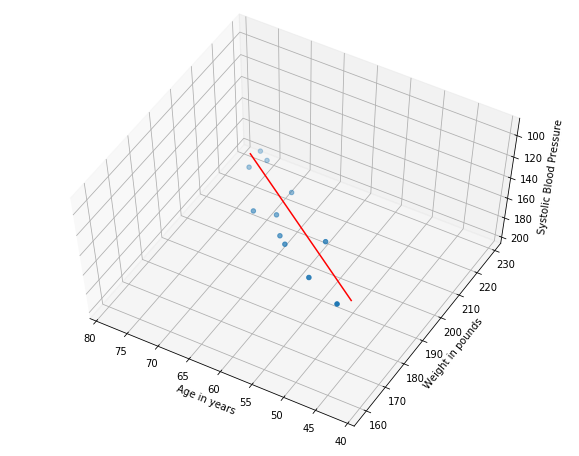

In [10]:
W1 = np.copy(weights)
[best_val, record] = gradient_descent(Xnorm, y, W1, f, alpha=0.02, num_iters=2000)
print (best_val)
updated_weights = best_val['weights']

plot_figure(X[:,0], X[:,1], y, updated_weights, Xnorm, mu, sd)



Iteration 0: Error: 149.063657
Iteration 100: Error: 151.497463
Iteration 200: Error: 151.497463
Iteration 300: Error: 151.497463
Iteration 400: Error: 151.497463
Iteration 500: Error: 151.497463
Iteration 600: Error: 151.497463
Iteration 700: Error: 151.497463
Iteration 800: Error: 151.497463
Iteration 900: Error: 151.497463
Iteration 1000: Error: 151.497463
Iteration 1100: Error: 151.497463
Iteration 1200: Error: 151.497463
Iteration 1300: Error: 151.497463
Iteration 1400: Error: 151.497463
{'sse': 149.06365723871377, 'weights': array([ 149.34539807,   12.59553906,   12.60464433])}


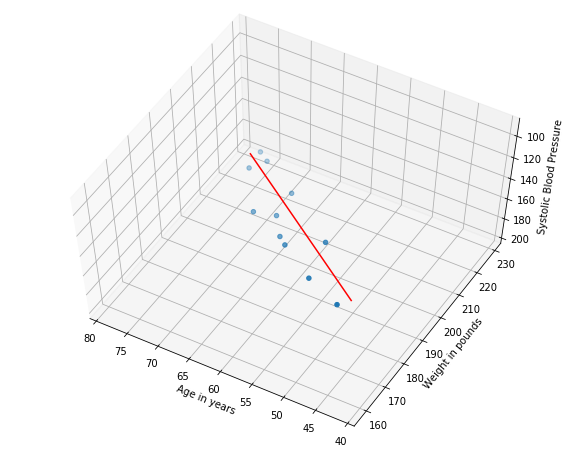

In [12]:
W2 = np.copy(weights)
[best_val, record] = compute_newton(Xnorm, y, W2, f, num_iters=1500)
print (best_val)

updated_weights = best_val['weights']

plot_figure(X[:,0], X[:,1], y, updated_weights, Xnorm, mu, sd)